In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3  # Change to InceptionV3
from sklearn.model_selection import train_test_split

In [2]:
# Set the desired resized image dimensions
img_width, img_height = 224, 224

# Set the batch size and number of epochs
batch_size = 32
epochs = 50

In [3]:

# Set the path to your CSV file
csv_path = "C:/Users/abida/Desktop/car_damage/datasets/Ai_Or_Not/fake_real_dataset.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [4]:

# Create a data generator with data augmentation and resizing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=lambda x: tf.image.resize(x, (img_width, img_height))
)

# Create a data generator for the training set
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_dataframe(
    val_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Create a data generator for the test set
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1750 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.


Inception v3

In [12]:
# Build the model
inception_model = Sequential()

# Add a pre-trained CNN (e.g., InceptionV3) as a feature extractor
base_model = InceptionV3(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')  # Change to InceptionV3

base_model.trainable = False

inception_model.add(base_model)
inception_model.add(Flatten())
inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(1, activation='sigmoid'))
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 28356641 (108.17 MB)
Trainable params: 6553857 (25.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [13]:
# Compile the model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_inception=inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
54/54 [==============================] - 229s 4s/step - loss: 2.6570 - accuracy: 0.7974 - val_loss: 0.0468 - val_accuracy: 1.0000
Epoch 2/50
54/54 [==============================] - 181s 3s/step - loss: 0.1512 - accuracy: 0.9406 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 3/50
54/54 [==============================] - 180s 3s/step - loss: 0.1382 - accuracy: 0.9540 - val_loss: 0.0706 - val_accuracy: 0.9688
Epoch 4/50
54/54 [==============================] - 180s 3s/step - loss: 0.1188 - accuracy: 0.9540 - val_loss: 0.3115 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 208s 4s/step - loss: 0.0937 - accuracy: 0.9662 - val_loss: 0.2109 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 198s 4s/step - loss: 0.0830 - accuracy: 0.9674 - val_loss: 0.1451 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 180s 3s/step - loss: 0.1363 - accuracy: 0.9529 - val_loss: 0.1946 - val_accuracy: 0.9062
Epoch 8/50
54

In [14]:
inception_model.save("inception.h5")

c:\Users\abida\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
test_loss, test_accuracy = inception_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')
predictions = inception_model.predict(test_generator)
threshold = 0.5  
predicted_labels = (predictions > threshold).astype(int)
# Display the predicted labels
print("Predicted Labels:")
print(predicted_labels)

19/19 [==============================] - 77s 4s/step - loss: 0.0720 - accuracy: 0.9753
Test Accuracy: 97.53%
Test Loss: 0.0720
19/19 [==============================] - 72s 3s/step
Predicted Labels:
[[1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [

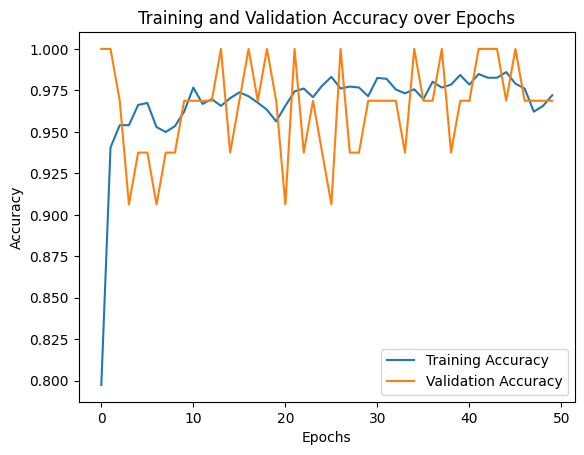

19/19 [==============================] - 72s 4s/step - loss: 0.0698 - accuracy: 0.9786
Test Accuracy: 97.86%
Test Loss: 0.0698


In [16]:
import matplotlib.pyplot as plt
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = inception_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

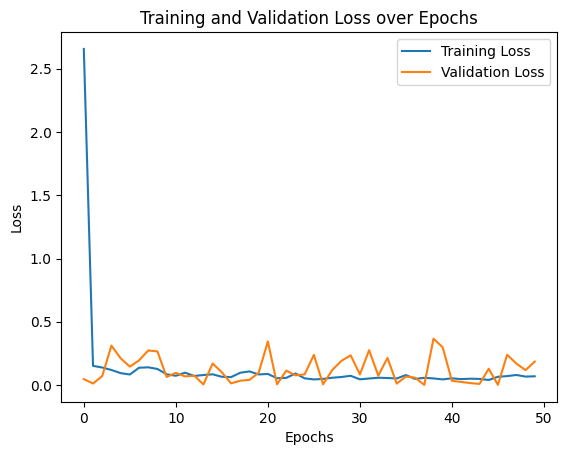

In [17]:
all_train_loss_histories = [history_inception.history['loss']]
all_val_loss_histories = [history_inception.history['val_loss']]

plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

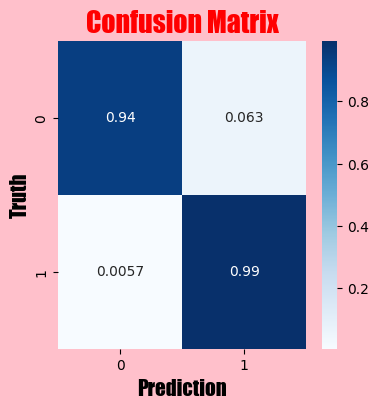

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       255
           1       0.96      0.99      0.98       353

    accuracy                           0.97       608
   macro avg       0.97      0.97      0.97       608
weighted avg       0.97      0.97      0.97       608



In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test and y_pred_labels are your true and predicted labels
test_labels = test_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
cm_percentages = cm / cm.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(4, 4), facecolor='pink', edgecolor='brown')
sn.heatmap(cm_percentages, annot=True, cmap="Blues")

plt.xlabel('Prediction', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.ylabel('Truth', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.title('Confusion Matrix', fontdict={'family': 'fantasy', 'color': 'red', 'size': 20})

plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))


VGG16

In [5]:

from tensorflow.keras.applications import VGG16
vgg_model = Sequential()

base_model = VGG16(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')  # Change to InceptionV3

#base_model.trainable = False

vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 17926209 (68.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:

vgg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Assuming X_train and y_train are already prepared with the new image size
history_vgg=vgg_model.fit(    
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 1/50
54/54 [==============================] - 2001s 37s/step - loss: 0.8589 - accuracy: 0.5349 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 1953s 36s/step - loss: 0.6921 - accuracy: 0.5594 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/50
54/54 [==============================] - 1956s 36s/step - loss: 0.6903 - accuracy: 0.5617 - val_loss: 0.6915 - val_accuracy: 0.5312
Epoch 4/50
54/54 [==============================] - 1956s 36s/step - loss: 0.6885 - accuracy: 0.5646 - val_loss: 0.6912 - val_accuracy: 0.5312
Epoch 5/50
54/54 [==============================] - 2831s 53s/step - loss: 0.6881 - accuracy: 0.5611 - val_loss: 0.6993 - val_accuracy: 0.4688
Epoch 6/50
54/54 [==============================] - 4034s 75s/step - loss: 0.6873 - accuracy: 0.5611 - val_loss: 0.7104 - val_accuracy: 0.4062
Epoch 7/50
54/54 [==============================] - 4043s 75s/step - loss: 0.6860 - accuracy: 0.5634 - val_loss: 0.6970 - val_accuracy: 0.5000